# Setup

In [1]:
import subprocess
# Check if packages are installed
def check_packages():
    try:
        with open('requirements.txt', 'r') as file:
            packages = file.read().splitlines()
            print(f"Packages to check: {packages}")  # Debug print
            for package in packages:
                try:
                    __import__(package)
                    print(f"{package} is already installed.")
                except ImportError:
                    print(f"{package} is not installed. Installing...")
                    subprocess.check_call(['pip', 'install', package])
                    print(f"{package} has been installed.")
    except Exception as e:
        print(f"An error occurred: {e}")  # Print any other errors

# Call the function to check and install packages
check_packages()

Packages to check: ['requests', 'aiohttp', 'pandas', 'tweepy', 'praw', 'ccxt', 'transformers', 'vaderSentiment', 'textblob', 'flask', 'plotly', 'beautifulsoup4', 'datetime', 'torch ', 'torchvision ', 'torchaudio', 'transformers', 'matplotlib']
requests is already installed.
aiohttp is already installed.
pandas is already installed.
tweepy is already installed.
praw is already installed.
ccxt is already installed.


c:\Users\UrsHu\Pillars\Learn\Academic\Master\Semestre 2\data analysis\crypto-sentiment-tracker\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


transformers is already installed.
vaderSentiment is already installed.
textblob is already installed.
flask is already installed.
plotly is already installed.
beautifulsoup4 is not installed. Installing...
beautifulsoup4 has been installed.
datetime is already installed.
torch  is not installed. Installing...
torch  has been installed.
torchvision  is not installed. Installing...
torchvision  has been installed.
torchaudio is already installed.
transformers is already installed.
matplotlib is already installed.


In [1]:
from datetime import datetime, timedelta
import time
import requests
from dotenv import load_dotenv
import os
import pandas as pd
from bs4 import BeautifulSoup
load_dotenv()

True

# Get News Articles

## News API

In [9]:
def standardize_date_format(df, date_column='date'):
    """Converts and standardizes the date format in a DataFrame column to 'YYYY-MM-DD HH:MM:SS'."""
    df[date_column] = pd.to_datetime(df[date_column]).dt.strftime('%Y-%m-%d %H:%M:%S')
    return df

In [10]:
from news_api import NewsAPI

LAST_MONTH = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')
LAST_WEEK = (datetime.today() - timedelta(days=7)).strftime('%Y-%m-%d')
TWO_DAYS_AGO = (datetime.today() - timedelta(days=2)).strftime('%Y-%m-%d')
YESTERDAY = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
TODAY = datetime.today().strftime('%Y-%m-%d')


# Create an instance of the NewsAPI
news_api = NewsAPI(api_key=os.getenv('news_api'))

# Fetch news articles about Bitcoin from a specific date range
crypto_news_df = news_api.get_news(topic='crypto', from_date=LAST_MONTH, to_date=TODAY)
crypto_news_df = standardize_date_format(crypto_news_df, 'date')

# Check if the DataFrame is not empty
if not crypto_news_df.empty:
    # Print the headlines along with the date and description
    print(f"Here are the articles about Crypto:\n")
    for index, row in crypto_news_df.iterrows():
        print(f"Date: {row['date']}")
        print(f"Headline: {row['headline']}")
        print(f"Description: {row['description']}\n")
else:
    print("No articles found for the given topic and date range.")

# Append the DataFrame to an existing CSV, without including the header again
crypto_news_df.to_csv('data/crypto_news.csv', mode='a', header=True, index=False)

Found 40 articles for topic: crypto
Here are the articles about Crypto:

Date: 2024-04-09 12:00:00
Headline: Paradigm leads $225 million round for Monad Labs, which is building a layer-1 blockchain to take on Ethereum and Solana
Description: The crypto firm founded by ex-Jump Crypto traders also received investment from Electric Capital and Neil Mehta's Greenoaks Capital.

Date: 2024-03-26 16:27:12
Headline: DOJ accuses crypto exchange KuCoin of money laundering violations and receiving billions in suspicious funds
Description: The Seychelles-based firm is one of the top crypto exchanges by trading volume.

Date: 2024-03-26 15:04:27
Headline: The U.S. is simplifying how to report crypto on your taxes in 2025. But what about this year?
Description: As April 15 nears, here’s everything the U.S.-based crypto community needs to know about filing taxes.

Date: 2024-04-05 17:09:41
Headline: FTX just sold nearly $2 billion of SOL at a steep discount. Here’s what that means for creditors
Descr

## seekalpha api

In [9]:
from seekingalpha import CryptoNewsSentiment

# Example usage
# Please replace 'your_api_key_here' with your actual RapidAPI key for Seeking Alpha.
# seekalpha_api = "your_api_key_here"
seekalpha_api = os.getenv('seeking_alpha')
sentiment_analysis = CryptoNewsSentiment(seekalpha_api)

### Date
# Get today's date with time set to 00:00:00 for the start of the day
start_of_today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

# Get the end of today by adding 1 day to the start of today and subtracting 1 second
end_of_today = start_of_today + timedelta(days=1) - timedelta(seconds=1)

# Convert to Unix timestamp
start_today_unix = int(time.mktime(start_of_today.timetuple()))
end_today_unix = int(time.mktime(end_of_today.timetuple()))

# use these timestamps as arguments for `since` and `until`
crypto_news_df = sentiment_analysis.get_crypto_news(since=start_today_unix, until=end_today_unix)
crypto_news_df = standardize_date_format(crypto_news_df, 'date')
# Check if the DataFrame is not empty
if not crypto_news_df.empty:
    # Print the headlines along with the date and description
    print(f"Here are the articles found:\n")
    for index, row in crypto_news_df.iterrows():
        print(f"Date: {row['date']}")
        print(f"Headline: {row['headline']}")
        print(f"Description: {row['description']}\n")
else:
    print("No articles found for the given topic and date range.")
    
# Append the DataFrame to an existing CSV, without including the header again
try:
    existing_data = pd.read_csv('data/crypto_news.csv')
except FileNotFoundError:
    existing_data = pd.DataFrame(columns=['date', 'headline', 'description'])

# Combine the new data with the existing data
combined_data = pd.concat([existing_data, bitcoin_news_df]).drop_duplicates()

# Write the combined data back to the CSV
combined_data.to_csv('data/crypto_news.csv', index=False)

print("The CSV file has been updated.")

No articles found for the given topic and date range.
The CSV file has been updated.


# Get stock prices

## Alphavantage

In [ ]:
from alpha_vantage import AlphaVantage
ALPHA_API_KEY = os.getenv('stock_api')
STOCK_ENDPOINT = 'https://www.alphavantage.co/query'
av = AlphaVantage(api_key=ALPHA_API_KEY, endpoint=STOCK_ENDPOINT)


## MarketStack API

In [4]:
from marketstack import StockPriceFetcher

#----- Stock Price Fetcher ------
fetcher = StockPriceFetcher('msft')  # Fetch end of day data for Microsoft
fetcher.fetch_price()

{'pagination': {'limit': 100, 'offset': 0, 'count': 100, 'total': 252}, 'data': {'name': 'Microsoft Corporation', 'symbol': 'MSFT', 'country': None, 'has_intraday': False, 'has_eod': True, 'eod': [{'open': 421.05, 'high': 421.87, 'low': 419.14, 'close': 420.72, 'volume': 21711778.0, 'adj_high': 421.87, 'adj_low': 419.12, 'adj_close': 420.72, 'adj_open': 420.96, 'adj_volume': 21871161.0, 'split_factor': 1.0, 'dividend': 0.0, 'symbol': 'MSFT', 'exchange': 'XNAS', 'date': '2024-03-28T00:00:00+0000'}, {'open': 424.2, 'high': 424.4, 'low': 419.01, 'close': 421.43, 'volume': 16679715.0, 'adj_high': 424.45, 'adj_low': 419.01, 'adj_close': 421.43, 'adj_open': 424.44, 'adj_volume': 16704978.0, 'split_factor': 1.0, 'dividend': 0.0, 'symbol': 'MSFT', 'exchange': 'XNAS', 'date': '2024-03-27T00:00:00+0000'}, {'open': 425.61, 'high': 425.99, 'low': 421.35, 'close': 421.65, 'volume': 16690800.0, 'adj_high': 425.99, 'adj_low': 421.35, 'adj_close': 421.65, 'adj_open': 425.61, 'adj_volume': 16725647.0, 

# Get Crypto Informatiosn
## Crypto API

In [1]:
from crypto_api import CryptoAPI

api = CryptoAPI()
api.get_crypto_listings()
api.save_crypto_listings_to_csv()

Number of cryptocurrencies: 3119
CSV file saved successfully


Fetching historical data for Dogecoin...
Fetching historical data for Shiba Inu...
Data has been written to meme_history.csv


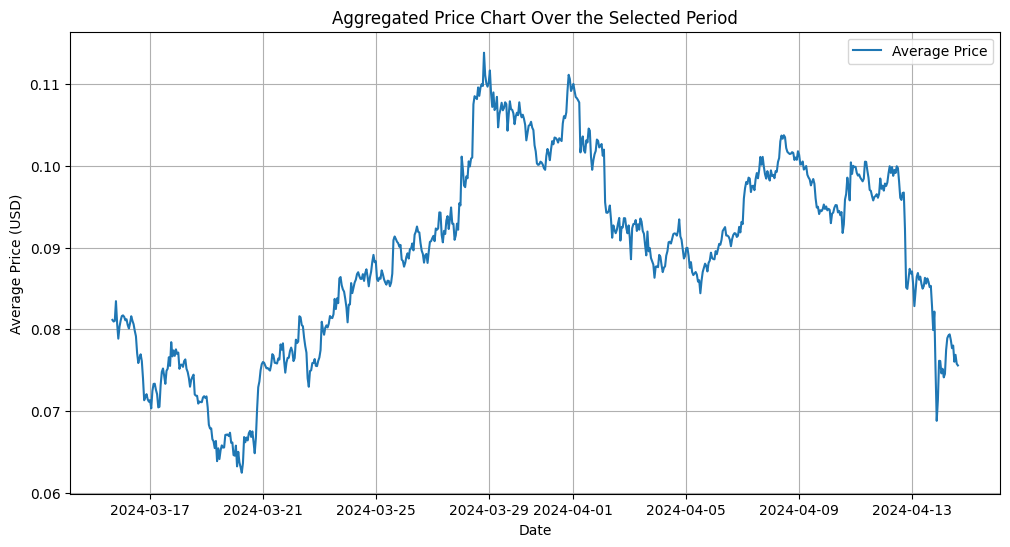

In [2]:
from coinrankingapi import CryptoDataFetcher
api_key = os.getenv('coinranking')  # Replace with your actual RapidAPI key
fetcher = CryptoDataFetcher(api_key, default_tags="meme", default_limit=2, default_time_period="30d")

# Example: Fetch and plot data using updated settings
data = fetcher.fetch_all_history()
if not data.empty:
    fetcher.write_to_csv(data, f'{fetcher.default_tags}_history.csv')
    fetcher.plot_aggregated_prices(data)
else:
    print("No data fetched.")


## Use .csv for testing purposes

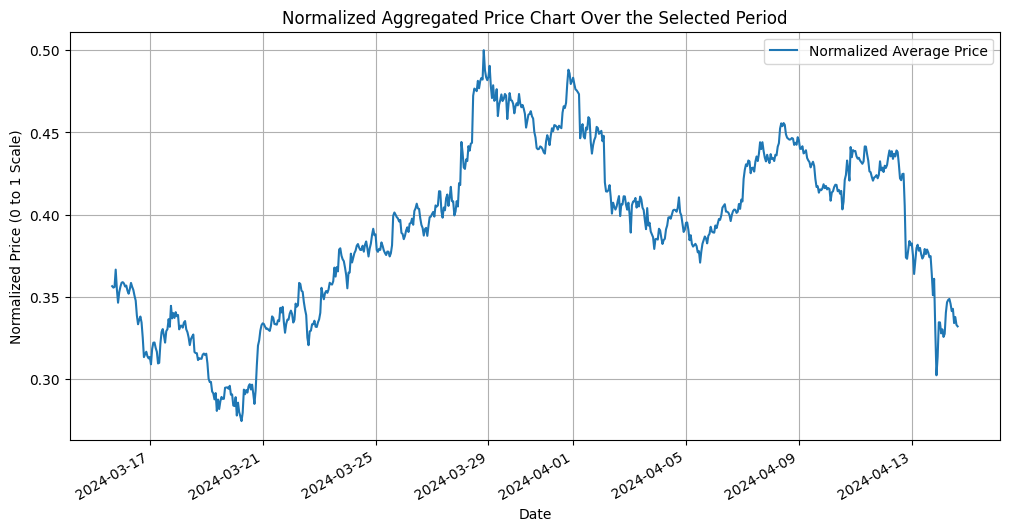

In [9]:
from coinrankingapi import CryptoDataFetcher
api_key = os.getenv('coinranking')  # Replace with your actual RapidAPI key
fetcher = CryptoDataFetcher(api_key)
data = pd.read_csv('data/meme_history.csv')
price_history = fetcher.plot_aggregated_prices(data)
price_history

# Sentiment

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import pandas as pd

# Assuming the data file is 'crypto_news.csv'
data_path = 'data/crypto_news.csv'

# Load data
df = pd.read_csv(data_path)

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
model = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Define a function to predict sentiment
def predict_sentiment(text):
    # Disable gradient computation for inference
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        # Detach the tensor and convert it to a numpy array
        predictions = predictions.detach().numpy()
    # Return only the positive sentiment probability
    return predictions[0, 0]

# Adding a column for sentiment
df['sentiment'] = df['description'].apply(predict_sentiment)

# Save the updated dataframe to CSV
df.to_csv('data/updated_crypto_news.csv', index=False)

# Display the dataframe
df


,date,headline,description,sentiment
0,2024-04-09 12:00:00,Paradigm leads $225 million round for Monad La...,The crypto firm founded by ex-Jump Crypto trad...,0.132681
1,2024-03-26 16:27:12,DOJ accuses crypto exchange KuCoin of money la...,The Seychelles-based firm is one of the top cr...,0.150637
2,2024-03-26 15:04:27,The U.S. is simplifying how to report crypto o...,"As April 15 nears, here’s everything the U.S.-...",0.032964
3,2024-04-05 17:09:41,FTX just sold nearly $2 billion of SOL at a st...,The bankrupt crypto exchange FTX has reportedl...,0.029471
4,2024-03-27 15:52:48,Judge rejects Coinbase’s ‘major questions doct...,Judge Katherine Failla ruled on Wednesday that...,0.058747
5,2024-03-28 16:07:47,Sam Bankman-Fried sentenced to 25 years in pri...,A jury convicted the disgraced founder of seve...,0.049845
6,2024-04-01 17:19:28,Is AI the new crypto? DeepMind co-founder says...,Surge in venture funding and public excitement...,0.743881
7,2024-04-03 17:07:49,‘We’re not believers’: Goldman Sachs doubles d...,“We do not think [crypto] is an investment ass...,0.058454
8,2024-04-01 10:00:00,Future of Finance: Coinbase’s Alesia Haas on w...,"Haas also discussed the crypto bull market, Sa...",0.044560
9,2024-04-11 11:00:00,Buying crypto for your kids? Here’s how to ens...,Don’t let lost keys or blockchain blackholes b...,0.034993


# Plot

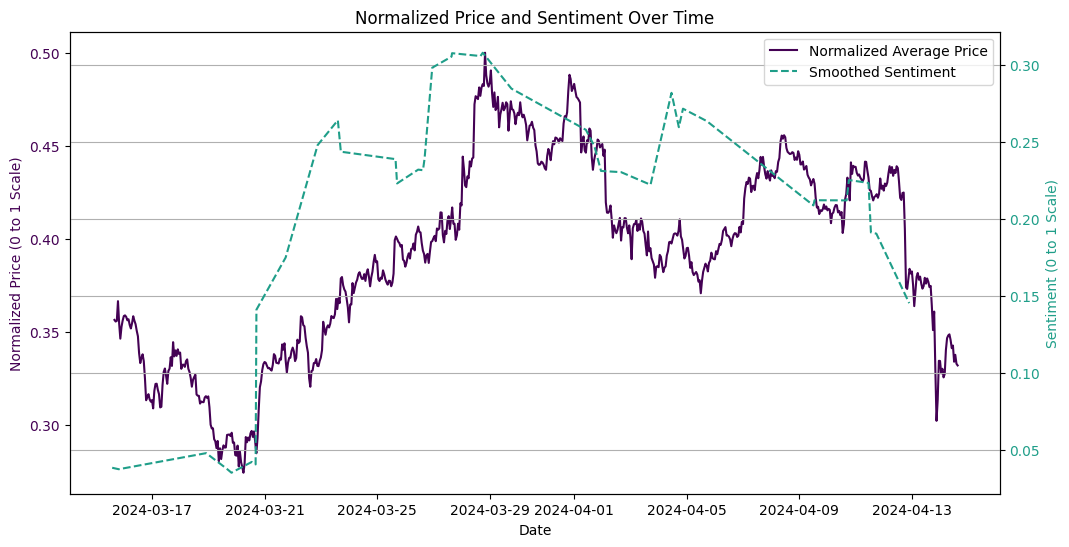

In [4]:
import os
import pandas as pd
from coinrankingapi import CryptoDataFetcher
api_key = os.getenv('coinranking')
fetcher = CryptoDataFetcher(api_key)

# Load historical price data
price_data = pd.read_csv('data/meme_history.csv')

# Load sentiment data
sentiment_data = pd.read_csv('data/crypto_news.csv')

# Specify the window size for smoothing the sentiment data
window_size = 15  # Change this as needed

# Plot price and sentiment data
plot_history = fetcher.plot_aggregated_prices(price_data, sentiment_data, window_size=window_size)